In [1]:
%matplotlib inline
from pylab import * # imshow()
import numpy as np
from tqdm import trange # progress bar

In [2]:
# load the mnist dataset

def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [3]:
X_train.reshape(-1, 28*28).shape


(60000, 784)

(<matplotlib.image.AxesImage at 0x7f82e5e20040>, 5)

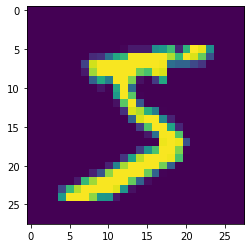

In [4]:
imshow(X_train[0]), Y_train[0]

In [9]:
# # model
# import torch
# import torch.nn as nn

# class BobNet(nn.Module):
#     def __init__(self):
#         super(BobNet, self).__init__()
#         self.l1 = nn.Linear(784, 128, bias=False)
#         self.act = nn.ReLU()
#         self.l2 = nn.Linear(128, 10)
#     def forward(self, x):
#         x = self.l1(x)
#         x = self.act(x)
#         x = self.l2(x)
#         return x

In [10]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(sci_mode=False)
class BobNet(torch.nn.Module):
  def __init__(self):
    super(BobNet, self).__init__()
    self.l1 = nn.Linear(784, 128, bias=False)
    self.l2 = nn.Linear(128, 10, bias=False)
    self.sm = nn.LogSoftmax(dim=1)
  def forward(self, x):
    x = F.relu(self.l1(x))
    x = self.l2(x)
    x = self.sm(x)
    return x

In [6]:
# model(torch.tensor(X_train[0:10].reshape((-1, 28*28))).float())

loss 0.13 accuracy 0.95: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 277.02it/s]


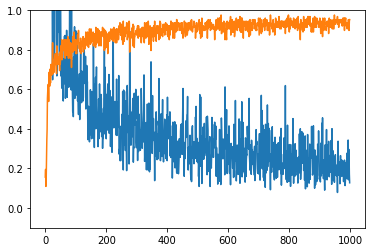

In [12]:
# training
model = BobNet()


"""
with torch.no_grad():
  model.l1.weight.copy_(torch.tensor(layer_init(784, 128).T))
  model.l2.weight.copy_(torch.tensor(layer_init(128, 10).T))
"""
loss_function = nn.NLLLoss(reduction = 'none')
#loss_function = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
losses, accuracies = [], []

BS = 128
for i in (t := trange(1000)):
    samp = np.random.randint(0, X_train.shape[0], size = (BS))
    
    X = torch.tensor(X_train[samp].reshape((-1, 28*28))).float()
    Y = torch.tensor(Y_train[samp]).long()
    model.zero_grad(set_to_none=True)
    out = model(X)
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    loss = loss_function(out, Y)
    loss = loss.mean()
    loss.backward()
    optim.step()
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    # print(loss)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
plt.ylim(-0.1, 1)
plot(losses)
plot(accuracies)

In [13]:
# evaluation
Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
(Y_test == Y_test_preds).mean()

0.9273

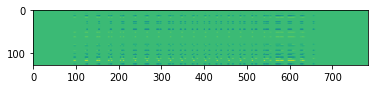

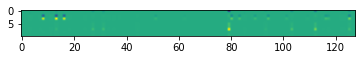

In [14]:
# compute gradients in torch

samp = [0, 1, 2, 3]
model.zero_grad()
out = model(torch.tensor(X_test[samp].reshape((-1, 28*28))).float())
out.retain_grad()
loss = loss_function(out, torch.tensor(Y_test[samp]).long()).mean()
loss.retain_grad()
loss.backward()
imshow(model.l1.weight.grad)
figure()
imshow(model.l2.weight.grad)


In [17]:
# copy weights from pytorch
l1 = model.l1.weight.detach().numpy().T
l2 = model.l2.weight.detach().numpy().T

# numpy forward pass
def forward(x):
    x = x.dot(l1)
    x = np.maximum(x, 0)
    x = x.dot(l2)
    return x

def numpy_eval():
    Y_test_preds_out = forward(X_test.reshape(-1, 28*28))
    Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
    return (Y_test == Y_test_preds).mean()

numpy_eval()

0.9273

In [23]:
# numpy forward and backward pass

def logsumexp(x):
    c = x.max(axis=1)
    return c + np.log(np.exp(x-c.reshape((-1, 1))).sum(axis=1))